# Deep Learning - Project 2

## Our approach

Approach we follow consists of two steps:

1. Train a CNN binary classifier on the set of crack / noncrack images knowing only their labels
2. Use a gradient-based interpretability technique to find regions that influenced the classification

The assumption is that regions forcing "crack" classification are the pixels corresponding to the cracks on the original image.

Experimentally, we came to the conclusion that outputs of interpretability techniques should be used to obtain pseudo-masks rather than bounding boxes. Some papers suggest bbox approaches for segmentation without masks, but cracks have very variable / irregular shapes that are not well representable by bounding boxes.

This notebook was run in Kaggle using Accelerator `GPU P100`. So the next cell supports a setup for Kaggle, however, running in local environment is also supported.

In [1]:
from pathlib import Path
import os

# Check if running on Kaggle
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    !rm -rf mask-free-segmentation
    !git clone https://github.com/AndrewChmutov/mask-free-segmentation
    !cd mask-free-segmentation && pip install . 1> /dev/null
    !ln -sf mask-free-segmentation/segmentation segmentation
    
    root_dir = Path("/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset")
    print("Running on Kaggle. Setup complete.")
else:
    root_dir = Path("data")
    print("Not running on Kaggle. Skipping Kaggle-specific setup.")

Cloning into 'mask-free-segmentation'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 204 (delta 101), reused 136 (delta 60), pack-reused 25 (from 1)
Receiving objects: 100% (204/204), 171.70 MiB | 36.07 MiB/s, done.
Resolving deltas: 100% (109/109), done.
Running on Kaggle. Setup complete.


In [2]:
from segmentation.model import DenseNetCrackModel, ResnetCrackModel, EfficientNetCrackModel, CaptumModel, TorchCamModel
from segmentation.loader import CrackDataset4, load
from segmentation.utils import get_model_path
from torchvision import transforms
from pathlib import Path
from PIL import Image
import gc
import numpy as np
import pandas as pd
import torch
import csv
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Path("models").mkdir(exist_ok=True)

In [60]:
def get_model_path(name: str, load: bool) -> str:
    path = f"models/{name}.pth"
    if not Path(path).is_file() and "KAGGLE_KERNEL_RUN_TYPE" in os.environ and load:
        path = f"/kaggle/input/{name}/pytorch/default/1/{name}.pth"
    assert Path(path).is_file() or not load, f"Couldn't find a model in {path}"
    return path


def mask2rle(img):
    '''
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def visualize_pair(pred, true):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(pred)
    axes[0].set_title("Predicted mask")
    axes[0].axis('off')

    axes[1].imshow(true)
    axes[1].set_title("Target mask")
    axes[1].axis('off')

    plt.show()

# Exploration

In [4]:
# Whether trained models are loaded from memory or trained on the fly
load_model = True

## Data augmentation and Mask extraction method
1. Train `Resnet50` with and without data augmentation
2. Run `Captum` and `CAM` on each
3. Calculate accuracy (IOU and Dice) for each pair
4. Decide which is the best pair (with / without data augmentation + Captum / CAM)

Original


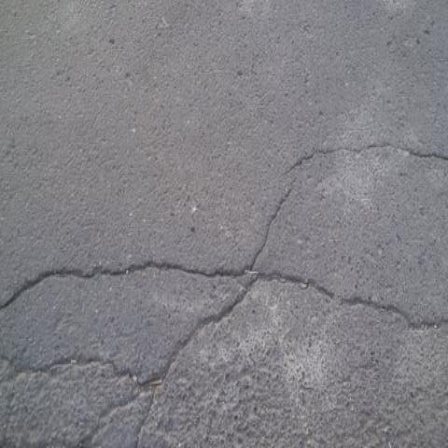

In [5]:
print("Original")
original = Image.open(root_dir / "train" / "images" / "CFD_002.jpg")
original

Transformed / augmented (scaled back to original shape)


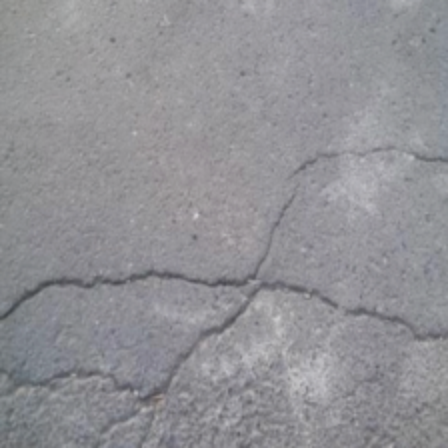

In [6]:
print("Transformed / augmented (scaled back to original shape)")

transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.Resize((448, 448)),
])(original)

### Training

We train resnet50 as an exemplary model to check whether data augmentation has positive effect on the final score. Moreover, we would compare two popular mask extraction methods (Captum and CAM) to find out which one is more suitable for crack detection.

In [7]:
# Configure
load_current_model = load_model
current_model_path = get_model_path("resnet50-without-augment", load_current_model)

torch.cuda.manual_seed(21)
torch.manual_seed(21)


transform_without_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
data_without_augmentation = load(
    root_dir,
    "3",
    transform=transform_without_augmentation,
    random_state=21
)
model_without_augmentation = ResnetCrackModel("50", device=device, path=current_model_path, load_model=load_current_model)
if not load_current_model:
    model_without_augmentation.train(
        data_without_augmentation.train_loader,
        data_without_augmentation.val_loader,
        epochs=50,
        stagnation_threshold=10,
    )
    model_without_augmentation.save()

crack_segmentation_dataset/test: y: 100%|██████████| 1695/1695 [00:00<00:00, 1102565.96it/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 90.3MB/s]


In [8]:
# Configure
load_current_model = load_model
current_model_path = get_model_path("resnet50-with-augment", load_current_model)

torch.cuda.manual_seed(21)
torch.manual_seed(21)


transform_with_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
data_with_augmentation = load(
    root_dir,
    "3",
    transform=transform_with_augmentation,
    random_state=21
)
model_with_augmentation = ResnetCrackModel("50", device=device, path=current_model_path, load_model=load_current_model)
if not load_current_model:
    model_with_augmentation.train(
        data_with_augmentation.train_loader,
        data_with_augmentation.val_loader,
        epochs=50,
        stagnation_threshold=10,
    )
    model_with_augmentation.save()

crack_segmentation_dataset/test: y: 100%|██████████| 1695/1695 [00:00<00:00, 1310961.70it/s]


### Mask generation

In [9]:
dataset = CrackDataset4(root_dir / "test", transform=transform_without_augmentation)

crack_segmentation_dataset/test: y: 100%|██████████| 1695/1695 [00:08<00:00, 189.04it/s]


In [10]:
limit = 100  # Determine best option based on 100 random images

indices = np.arange(len(dataset))
np.random.seed(21)
np.random.shuffle(indices)
indices = indices[:limit]
subset = torch.utils.data.Subset(dataset, indices)

evaluators = [
    (CaptumModel, {"percentile": 0.995, "device": device}),
    (TorchCamModel, {"version": "ScoreCAM", "percentile": 0.8, "device": device})
]
labels = ["Without augmentation", "With augmentation"]
models = [model_with_augmentation, model_without_augmentation]

results = {}
scores = {}


for evaluator_cls, evaluator_cfg in evaluators:
    for model, label in zip(models, labels):
        evaluator = evaluator_cls(model.model, **evaluator_cfg)
        print(f"{evaluator.name()} - {model.__class__.__name__} ({label}): ", end="")
        _results, _scores = evaluator.collect(subset, use_tqdm=False)

        results[evaluator.name()] = results.get(evaluator.name(), []) + [_results]
        scores[evaluator.name()] = scores.get(evaluator.name(), []) + [_scores]
        print(_scores)

CaptumModel - ResnetCrackModel (Without augmentation): {'IOU': 0.25100986689877514, 'Dice': 0.35212984053032603}
CaptumModel - ResnetCrackModel (With augmentation): {'IOU': 0.24375662499186257, 'Dice': 0.3392297059622432}
TorchCamModel - ScoreCAM - ResnetCrackModel (Without augmentation): {'IOU': 0.14527454486503688, 'Dice': 0.18997854406321613}
TorchCamModel - ScoreCAM - ResnetCrackModel (With augmentation): {'IOU': 0.13939002662275546, 'Dice': 0.17960857151856047}


Based on the results above we conclude that:

1. Data augmentation improves accuracy of crack detection
2. Captum is more suitable for crack detection

If we were to compare results obtained from Captum and CAM (namely, we used ScoreCAM in the above comparison) we would notice that Captum is returning a cloud of dots surrounding the crack, while CAM focuses on some parts of the crack and doesn't notice others (even change of percentile for TorchCamModel couldn't change that behaviour, thus we conclude that Captum is more suitable.

**Note:** Experimentally, we found out that **0.995** is the best percentile for CaptumModel. We don't provide the exact pathway here for the sake of brevity.

## Postprocessing

The losses obtained in the cell above are calculated after outputs of CNN models are postprocessed. Postprocessing significantly improves results, because by their nature, outputs of models are clouds of dots, thus morphological operations akin to closure, dilation, etc. are quite useful in highlighting crack-like shapes.

In the following cell with code we compare bare result of `resnet50` on a random test image with the postprocessed one.

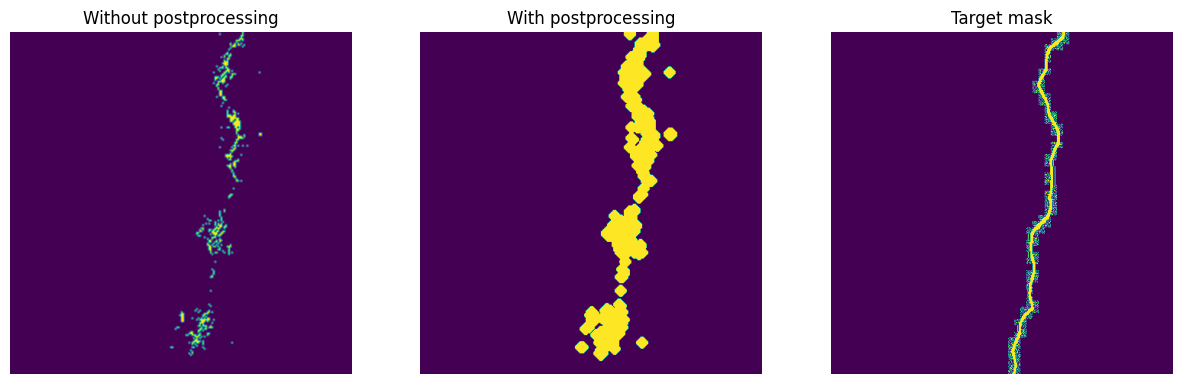

In [52]:
im_number = 6
indices = np.arange(len(dataset))
indices = indices[im_number:im_number+1]
subset = torch.utils.data.Subset(dataset, indices)

evaluators = [
    (CaptumModel, {"percentile": 0.995, "device": device})
]
labels = ["With augmentation"]
models = [model_with_augmentation]

for model, label in zip(models, labels):
    evaluator = CaptumModel(model.model, **{"percentile": 0.995, "device": device})
    result, _ = evaluator.collect(subset, use_tqdm=False)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[1].imshow(result[0][1])
    axes[1].set_title("With postprocessing")
    axes[1].axis('off')
    
    evaluator.postprocessors = []
    result, _ = evaluator.collect(subset, use_tqdm=False)
    
    axes[0].imshow(result[0][1])
    axes[0].set_title("Without postprocessing")
    axes[0].axis('off')

    axes[2].imshow(dataset.__getitem__(im_number)[2])
    axes[2].set_title("Target mask")
    axes[2].axis('off')

Postprocessing could be both useful and unwanted. On the one hand, it helps convering larger parts of desired shape, however, it also enlarges the areas that are not interesting. Nevertheless, practice shows that postprocessing improves both IOU and Dice metrics.

## Architecture selection

Apart from Resnet we trained some other CNN models, namely, `Efficientnet-B3` and `Densenet161` (we also tested that `Resnet50` was performing better than `Resnet18`, however, this comparison is not included in this notebook).

The cell below trains / loads the models and calculates their IOU / Dice metrics on the whole test set of 1695 images to get exact final accuracies for each model **(test set is used here only for architecture selection, it isn't used for training in any way)**.

**Note:** All the models are trained with the usage of data augmentation and Captum is used as a mask generation method.

In [53]:
model_configs = [
    (EfficientNetCrackModel, {"version": "efficientnet-b3", "device": device, "path": get_model_path("efficientnet-b3", load_model), "load_model": load_model}),
    (DenseNetCrackModel, {"version": "161", "device": device, "path": get_model_path("densenet161", load_model), "load_model": load_model}),
    (ResnetCrackModel, {"version": "50", "device": device, "path": get_model_path("resnet50-with-augment", load_model), "load_model": load_model}),
]

results = {}
for model_cls, model_config in model_configs:
    gc.collect()
    torch.cuda.empty_cache()

    model = model_cls(**model_config)
    if not model_config.get("load_model"):
        model.train(
            data_with_augmentation.train_loader,
            data_with_augmentation.val_loader,
            epochs=50,
            stagnation_threshold=10,
        )
        model.save()
        
    evaluator = CaptumModel(model.model, percentile=0.995, device=device)
    print(f"{model.__class__.__name__}: ", end="")
    _results, _scores = evaluator.collect(dataset, use_tqdm=False)

    results[model.__class__.__name__] = (_results)
    print(_scores)

    del model

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 132MB/s] 


Loaded pretrained weights for efficientnet-b3
EfficientNetCrackModel: {'IOU': 0.23102831512493482, 'Dice': 0.30518237837593765}


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 58.5MB/s] 


DenseNetCrackModel: {'IOU': 0.27032582181568454, 'Dice': 0.3624977453570962}
ResnetCrackModel: {'IOU': 0.2755788233044716, 'Dice': 0.369113090089202}


The best identified model is `Resnet50`. It has both the highest IOU and Dice metrics, however, `Densenet161` has also a strong score. Results of `Resnet50` are the ones we submit on Kaggle.

In [54]:
csv_file_name = "output_resnet.csv"
outputs = []
file_paths = []

for name, predicted, expected in results["ResnetCrackModel"]:
    name = list(name[0].split("/"))[-1]
    file_paths.append(name)
    outputs.append(predicted)

with open(csv_file_name, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["file", "crack"])
    for file, output in zip(file_paths, outputs):
        csv_writer.writerow([file, mask2rle((output > 0.5).astype(np.uint8))])

## Results analysis

The results we obtained show variability. Some cracks are identified very well but some are not detected by the CNN. While IOU of 0.27 might be considered relatively low for segmentation with a mask, it could be a nice result for segmentation without a mask and on such a diverse dataset.

We could potentially push accuracy forward by utilizing even deeper networks or by implementing more complex postprocessing, however, that wouldn't change the core idea behind our approach.

When it comes to comparison of final results with other students, there was only one more team submitting their pro outputs on Kaggle, and our result is about 45% more accurate. Moreover, our result surpassed more than 40% of submissions for advanced version of the problem (the one allowing to use the masks) which also speaks in favor of our solution.

Below we present some results of the model (both good and bad representatives).

Good fit


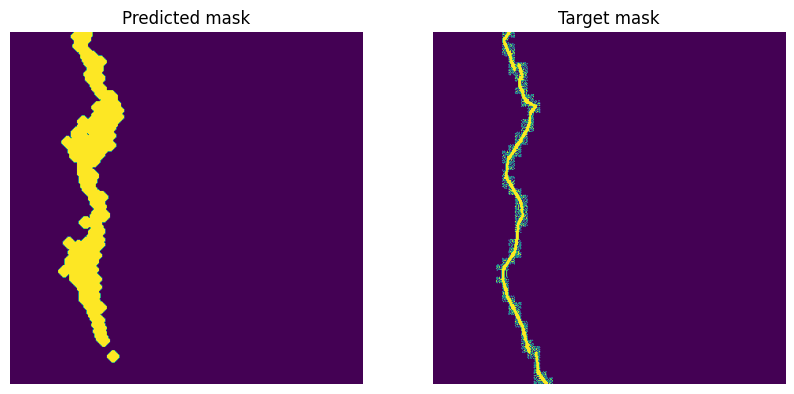

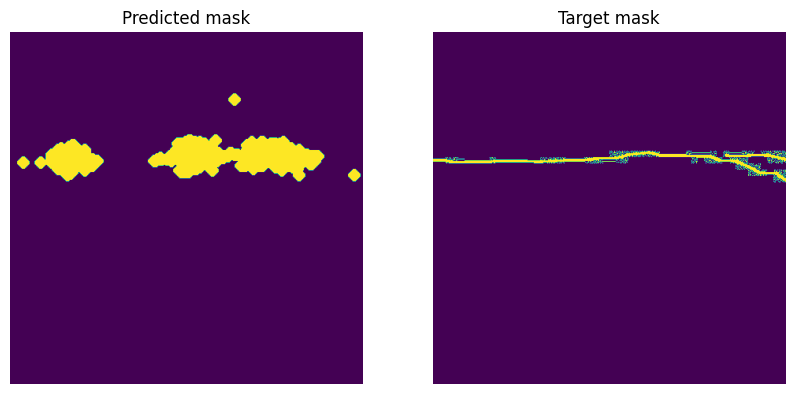

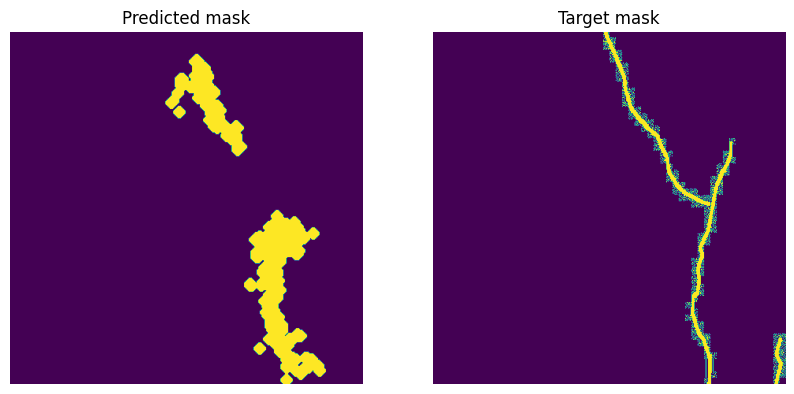

In [76]:
print("Good fit")
visualize_pair(results["ResnetCrackModel"][0][1], results["ResnetCrackModel"][0][2])
visualize_pair(results["ResnetCrackModel"][9][1], results["ResnetCrackModel"][9][2])
visualize_pair(results["ResnetCrackModel"][16][1], results["ResnetCrackModel"][16][2])

Bad fit


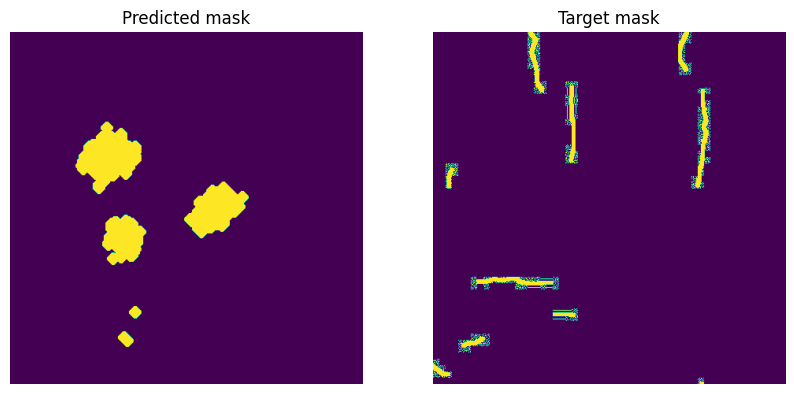

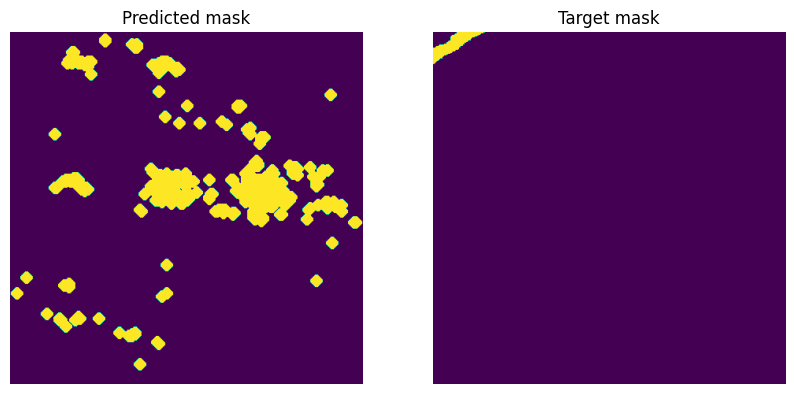

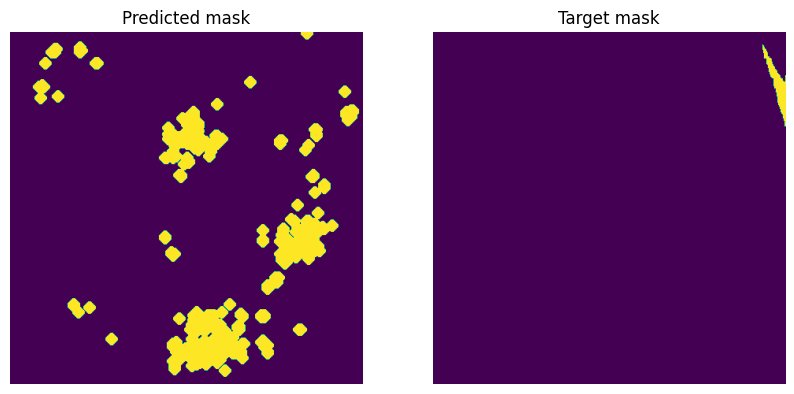

In [75]:
print("Bad fit")
visualize_pair(results["ResnetCrackModel"][2][1], results["ResnetCrackModel"][2][2])
visualize_pair(results["ResnetCrackModel"][8][1], results["ResnetCrackModel"][8][2])
visualize_pair(results["ResnetCrackModel"][17][1], results["ResnetCrackModel"][17][2])